# Module 9 - Water, Peptides, and Multi-body Potentials

# Goals

- Learn about the simulation of water and biomolecules such as peptides
- Learn about multibody potentials used to describe the complex geometries of molecules

## Force-fields and Multibody Potentials

Simulation of complex macromolecules such as proteins, lipids, nucleic acids, etc. requires definition of multi-body potentials that can constrain the geometry of these molecules to match known experimental quantities. An excellent description of commonly used bonded-potentials is given here https://computecanada.github.io/molmodsim-md-theory-lesson-novice/01-Force_Fields_and_Interactions/index.html#bonded-terms . In addition to these multi-body potentials and Lennard-Jones non-bonded interactions, most biomolecules of interest are polar and therefore we must also consider charged interactions (i.e., coulomb forces). These coulombic forces cannot treated with a simple cut-off as we do with the Lennard-Jones forces, but must be computed using various reciprocal-space methods such as particle-mech Ewald (PME): https://computecanada.github.io/molmodsim-md-theory-lesson-novice/06-electrostatics/index.html and https://courses.physics.illinois.edu/phys466/sp2013/projects/2002/team1/Ewald3.htm .

In addition to the parameters for our molecule of interest, we must also pay close attention to the treatment of water as it is an ubiquitous component and an essential driving force of molecular interactions. There are a large number of water models with various levels of complexity that have been developed over the years. A nice summary is provided here: https://computecanada.github.io/molmodsim-md-theory-lesson-novice/09-water_models/index.html .

A combination of consistent parameters used to simulate a general class of molecules such as proteins is called a **force-field**. Force-fields are usually developed for a particular application based on experimental structural data (e.g., X-ray crystallography, NMR, spectroscopy, etc.), thermodynamic properties (e.g., density, heat of vaporization, surface tension, free energy of solvation, etc.), and quantum mechanical data (e.g., Hartree-Fock and Density Functional Theory calculations). Here's a list of commonly used force-fields for the simulation of biomolecules:

- **CHARMM36** - General FF for use with proteins, lipids, carbohydrates, nucleic acids (DNA/RNA) and small molecules. https://mackerell.umaryland.edu/charmm_ff.shtml
- **AMBER** - General FF for use with proteins, lipids, carbohydrates, nucleic acids (DNA/RNA) and small molecules.  https://ambermd.org/AmberModels.php
- **GROMOS** - General FF for use with proteins, lipids, carbohydrates, and small molecules. https://www.gromos.net/
- **OPLS** - General FF for use with proteins, lipids, polymers, and small molecules. https://zarbi.chem.yale.edu/oplsaam.html

<div class="span alert alert-success">
<h2> Programming challenge </h2>

Let's generate a simulation of the simple 'alanine dipeptide' in a box of water. The alanine dipeptide consists of two alanine aminoacids joined by a peptide linkage.
    
<img src="https://pubs.acs.org/cms/10.1021/ct800153n/asset/images/large/ct-2008-00153n_0004.jpeg" width=300px>

The alanine dipeptide is unique in that the N and C termini are not in the conventional charged states, but instead have acetyl/methyl caps.

Let's copy the initial files into our directory

`cp -vR /home/hub_data_share/module_09/ala2_charmm36 .`
    
The PDB (`alanine_charmm/alanine_dipeptide.pdb`) of our initial structure looks like this:
    
```
TITLE     Georgetown Riga Oslo Madrid Amsterdam Chisinau Stockholm
REMARK    THIS IS A SIMULATION BOX
CRYST1   27.222   27.222   27.222  90.00  90.00  90.00 P 1           1
MODEL        1
ATOM      1 HH31 ACE X   1      14.644  17.276  15.674  1.00  0.00           H
ATOM      2  CH3 ACE X   1      15.139  16.419  15.218  1.00  0.00           C
ATOM      3 HH32 ACE X   1      15.507  15.754  15.999  1.00  0.00           H
ATOM      4 HH33 ACE X   1      15.976  16.763  14.610  1.00  0.00           H
ATOM      5  C   ACE X   1      14.189  15.649  14.338  1.00  0.00           C
ATOM      6  O   ACE X   1      13.019  15.999  14.198  1.00  0.00           O
ATOM      7  N   ALA X   2      14.689  14.489  13.798  1.00  0.00           N
ATOM      8  H   ALA X   2      15.678  14.320  13.918  1.00  0.00           H
ATOM      9  CA  ALA X   2      13.899  13.539  12.918  1.00  0.00           C
ATOM     10  HA  ALA X   2      13.152  14.164  12.429  1.00  0.00           H
ATOM     11  CB  ALA X   2      14.889  13.009  11.838  1.00  0.00           C
ATOM     12  HB1 ALA X   2      15.638  12.374  12.311  1.00  0.00           H
ATOM     13  HB2 ALA X   2      14.341  12.431  11.094  1.00  0.00           H
ATOM     14  HB3 ALA X   2      15.382  13.851  11.352  1.00  0.00           H
ATOM     15  C   ALA X   2      13.149  12.439  13.598  1.00  0.00           C
ATOM     16  O   ALA X   2      13.759  11.729  14.388  1.00  0.00           O
ATOM     17  N   NME X   3      11.819  12.279  13.318  1.00  0.00           N
ATOM     18  H   NME X   3      11.411  12.967  12.701  1.00  0.00           H
ATOM     19  CH3 NME X   3      10.949  11.199  13.838  1.00  0.00           C
ATOM     20 HH31 NME X   3      11.531  10.542  14.484  1.00  0.00           H
ATOM     21 HH32 NME X   3      10.129  11.635  14.408  1.00  0.00           H
ATOM     22 HH33 NME X   3      10.546  10.624  13.005  1.00  0.00           H
TER
ENDMDL
```
<br/>
Notice that our system consists of 3 residues ACE-ALA-NME rather than being ALA-ALA. This is necessary so that GROMACS can process the chemistry of the termini correctly, but it still made of two alanine residues.
    
The first step we need to take is to process the PDB file with the `gmx pdb2gmx` tool to determine a topology for the molecule based on a particular parametrization/forcefield.

`gmx pdb2gmx -f alanine_dipeptide.pdb -o alanine_dipeptide_pdb2gmx.pdb -p topol.top -ter`

at the first prompt select the CHARMM36m force-field

`9: CHARMM36m all-atom force field`

at the second prompt select the original TIP3P water model
    
`2: TIP3P_ORIGINAL Original TIP3P water model`

at the third and fourth prompts select `None` for the N and C termini. If everything worked as expected, you should now have two new files called `alanine_dipeptide_pdb2gmx.pdb` and `topol.top`. The first file is the processed PDB file with atom and residue names that match the force-field. The second file has all the bonded and non-bonded definitions to simulate the bare molecule. The `-ter` flag tells `gmx pdb2gmx` to interactively ask the user how to treat the end termini of the protein instead of the default behaviour of positively charged N-terminus (NH3+) and negatively charged C-terminus (COO-).

Our next step is to *solvate* the alanine dipeptide by putting it into a box full of water (avoiding clashes with any nearby molecules). We can do this with the GROMACS `gmx solvate` utility:
    
`gmx solvate -cp alanine_dipeptide_pdb2gmx.pdb -cs spc216.gro -p topol.top -box 3 3 3 -o alanine_dipeptide_pdb2gmx_solvated.pdb`

The input `-cs spc216.gro` tells the utility to read a small (only 216 waters) pre-equilibrated box of water that is part of the GROMACS files. The `-p topol.top` tells the utility to modify the topology file to include the newly added number of molecules. The `-box 3 3 3` option tells the program to use a simulation box of dimensions 3x3x3 nm, and finally the last option tells the program the name of the fully solvated structure.

Now that our system is solvated we will proceed to structurally/energy **minimize** it. The minimization/optimization process ensures that there aren't any atom clashes or strained configurations. Energy minimization in GROMACS works similarly to an MD simulation except that we use a different integrator. Setting the `integrator = steep` chooses the steepest descent minimization algorithm which finds the lowest energy/force configuration over a given number of steps. It is usually sufficient to run 500-1000 steps of energy minimization. The `emin.mdp` file looks like this:
    
```
integrator              = steep
dt                      = 0.002
nsteps                  = 1000
nstcalcenergy           = 10
nstenergy               = 10
nstlog                  = 10
nstxout                 = 10
nstxout-compressed      = 10
;
cutoff-scheme           = Verlet
nstlist                 = 20
rlist                   = 1.2
vdwtype                 = Cut-off
vdw-modifier            = Force-switch
rvdw_switch             = 1.0
rvdw                    = 1.2
coulombtype             = PME
rcoulomb                = 1.2
;
tcoupl                  = v-rescale
tc_grps                 = System
tau_t                   = 1.0
ref_t                   = 310
;
pcoupl                  = c-rescale
pcoupltype              = isotropic
tau_p                   = 5.0
compressibility         = 4.5e-5
ref_p                   = 1.0
;
constraints             = h-bonds
constraint_algorithm    = LINCS
;
nstcomm                 = 100
comm_mode               = linear
comm_grps               = System
;

```
<br/>

To execute the energy minimization we first run `gmx grompp` followed by `gmx mdrun`:

```
gmx grompp -f emin.mdp -c alanine_dipeptide_pdb2gmx_solvated.pdb -o emin.tpr

gmx mdrun -nt 1 -deffnm emin -c alanine_dipeptide_emin.pdb
```
<br/>
    
The output from the minimization procedure looks like this:
    

```
    Steepest Descents:
   Tolerance (Fmax)   =  1.00000e+01
   Number of steps    =         1000

Energy minimization reached the maximum number of steps before the forces
reached the requested precision Fmax < 10.

writing lowest energy coordinates.

Steepest Descents did not converge to Fmax < 10 in 1001 steps.
Potential Energy  = -4.1318629e+04
Maximum force     =  9.7218390e+02 on atom 5
Norm of force     =  2.8738144e+01

GROMACS reminds you: "If There Is No Guitar In The House, You Know It's Owner Can Not Be Trusted" (Gogol Bordello)
```
<br/>

The maximum force on any atom after the minimization should be ~$10^2-10^3$. If the force is much larger than that, then there may be a substantial problem with your structure, which will cause problems later on during the simulation. 
<br/>

Let's visualize the resulting trajectory from the energy minimization:

In [2]:
import numpy as np
from matplotlib import pylab as plt
# Visualize with MDTraj + NGLView
import mdtraj as mdt
import nglview as nv

gmx_traj = mdt.load('ala2_charmm36/emin.trr', top='ala2_charmm36/alanine_dipeptide_pdb2gmx_solvated.pdb')
view = nv.show_mdtraj(gmx_traj)
view.clear_representations()
view.add_representation('ball+stick', selection='not water')
#view.add_representation('licorice', selection='water')
view.add_representation('unitcell', selection='all')
view

NGLWidget(max_frame=79)

Notice that we have added some additional elements to our visualization using NGLView. Here's a list of some useful representations available (a complete list is give here https://nglviewer.org/ngl/api/manual/molecular-representations.html):

- axes
- backbone
- ball+stick
- base
- cartoon
- distance
- label
- licorice
- line
- point
- ribbon
- rope
- spacefill
- surface
- tube
- unitcell

NGLView also supports a powerfull selection language: https://nglviewer.org/ngl/api/manual/usage/selection-language.html

More advanced NGLView usage is demonstrated here:
- https://projects.volkamerlab.org/teachopencadd/talktorials/T017_advanced_nglview_usage.html
- https://nglviewer.org/ngl/api/manual/index.html

**Try generating new views using different representations and/or selections.**

<div class="span alert alert-success">
<h2> Programming challenge </h2>

Now that we have minimized our system, let's proceed to running the MD simulation:

```
gmx grompp -f grompp.mdp -c alanine_dipeptide_emin.pdb -o equilibration.tpr

gmx mdrun -nt 1 -deffnm equilibration -c alanine_dipeptide_10ps.pdb
```
<br/>
    
Copy the visualization code above to generate a new viualization of the MD run. The topology/structure file should be `ala2_charmm36/alanine_dipeptide_emin.pdb` and the trajectory file `ala2_charmm36/equilibration.xtc`.

In [3]:
## INSERT CODE HERE ##
gmx_traj = mdt.load('ala2_charmm36/equilibration.xtc', top='ala2_charmm36/alanine_dipeptide_emin.pdb')
view = nv.show_mdtraj(gmx_traj)
view.clear_representations()
view.add_representation('ball+stick', selection='not water')
#view.add_representation('licorice', selection='water')
view.add_representation('unitcell', selection='all')
view

NGLWidget(max_frame=50)

<div class="span alert alert-success">
<h2> Programming challenge </h2>

Let's now run a new simulation using a different force-field, amber99sb-ildn. Start by copying the starting files from the hub_data_share folder into a new folder called ala2_amber:
    
```
cd ../
cp -vR /home/hub_data_share/module_09/ala2_amber .
cd ala2_amber
```
<br/>

We will follow the same general process as we did with the CHARMM36 simulation:
    
```
## Step 1. Generate the topology
## select 6: AMBER99SB-ILDN protein, nucleic AMBER94 (Lindorff-Larsen et al., Proteins 78, 1950-58, 2010)
## select 1: TIP3P     TIP 3-point, recommended

gmx pdb2gmx -f alanine_dipeptide.pdb -o alanine_dipeptide_pdb2gmx.pdb -p topol.top -ter

## Step 2. Solvate the system
gmx solvate -cp alanine_dipeptide_pdb2gmx.pdb -cs spc216.gro -p topol.top -box 3 3 3 -o alanine_dipeptide_pdb2gmx_solvated.pdb

## Step 3. Minimize it
gmx grompp -f emin.mdp -c alanine_dipeptide_pdb2gmx_solvated.pdb -o emin.tpr

gmx mdrun -nt 1 -deffnm emin -c alanine_dipeptide_emin.pdb

## Step 4. Run the simulation
gmx grompp -f grompp.mdp -c alanine_dipeptide_emin.pdb -o equilibration.tpr

gmx mdrun -nt 1 -deffnm equilibration -c alanine_dipeptide_10ps.pdb
```
<br/>

Notice that the mdp file for the AMBER FF simulation is slightly different compared to CHARMM36, in particular with regard to the treatment of cut-offs and non-bonded forces:

```
cutoff-scheme           = Verlet
nstlist                 = 20
rlist                   = 1.0
vdwtype                 = Cut-off
vdw-modifier            = Potential-shift-Verlet
rvdw                    = 1.0
coulombtype             = PME
rcoulomb                = 1.0
DispCorr                = EnerPres
```
<br/>

Copy the visualization code above to generate a new viualization of the MD run. The topology/structure file should be `ala2_amber/alanine_dipeptide_emin.pdb` and the trajectory file `ala2_amber/equilibration.xtc`.

In [14]:
## INSERT CODE HERE ##
gmx_traj = mdt.load('ala2_amber/equilibration.xtc', top='ala2_amber/alanine_dipeptide_emin.pdb')
view = nv.show_mdtraj(gmx_traj)
view.clear_representations()
view.add_representation('ball+stick', selection='not water')
#view.add_representation('licorice', selection='water')
view.add_representation('unitcell', selection='all')
view

NGLWidget(max_frame=50)

<div class="span alert alert-success">
<h2> Programming challenge </h2>

Let's compare our two simulations using different force-fields through the analysis of dihedral angles. The configuration of a residue in a protein is often characterizes by two angles, $\psi$ and $\phi$:

<img src="https://fhedin.com/wp-content/uploads/2019/06/samc-ala2.jpg" width=300px>

These two angles are often graphed together in what is called a Ramachandran plot (named after G. N. Ramachandran, https://en.wikipedia.org/wiki/G._N._Ramachandran). A Ramachandran plot often looks like this:
    
<img src="https://www.cryst.bbk.ac.uk/PPS95/course/3_geometry/rama.gif" width=300px>

See here more a more thorough explanation: https://www.cryst.bbk.ac.uk/PPS95/course/3_geometry/rama.html .

We will use the MDAnalysis (https://www.mdanalysis.org/) python library to do create a Ramachandran plot from our simulated trajectories (https://docs.mdanalysis.org/1.1.0/documentation_pages/analysis/dihedrals.html). 



<Axes: xlabel='$\\phi$', ylabel='$\\psi$'>

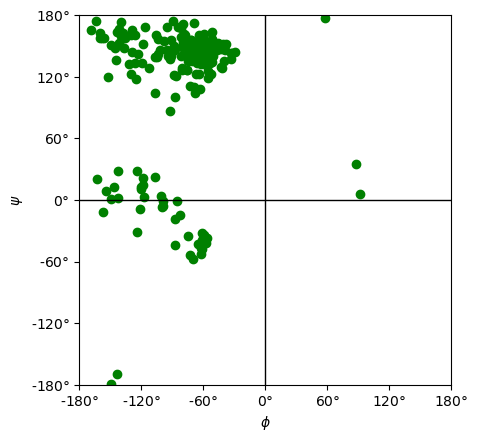

In [10]:
import MDAnalysis as MDA
import MDAnalysis.transformations as trans
from MDAnalysis.analysis.dihedrals import Ramachandran
import matplotlib.pyplot as plt

u = MDA.Universe('ala2_charmm36/equilibration.tpr', 'ala2_charmm36/equilibration_10ns.xtc')

protein = u.select_atoms('protein')
system = u.select_atoms('all')
transforms = [trans.unwrap(system), trans.center_in_box(protein), trans.wrap(protein)]
u.trajectory.add_transformations(*transforms)

R = Ramachandran(protein).run(step=50)

fig, ax = plt.subplots(figsize=plt.figaspect(1))
R.plot(ax=ax, color='g', marker='o')
R.results

In [11]:
R.results

{'angles': array([[[-130.08725775,  123.13050565]],

       [[ -51.33174262,  156.49256319]],

       [[ -69.04248196,  109.81815017]],

       [[-120.0987357 ,   12.7300079 ]],

       [[-118.00440261,   14.34785817]],

       [[ -61.97380458,  -52.93655648]],

       [[ -82.95917685,  -15.09894151]],

       [[ -61.27966536,  -47.67070843]],

       [[ -61.33317866,  -38.92371997]],

       [[ -87.61083053,  -43.53913856]],

       [[ -59.91904948,  -34.61507913]],

       [[-146.12523608,   12.5535078 ]],

       [[ -92.57678384,   86.4761164 ]],

       [[-129.2709556 ,  143.61896959]],

       [[ -76.69661949,  140.69826395]],

       [[ -53.24221207,  133.43010862]],

       [[ -80.66511548,  126.9632185 ]],

       [[-163.810778  ,  173.95712417]],

       [[-141.81341946,  151.51544107]],

       [[ -65.23712428,  149.30567353]],

       [[ -69.10606683,  172.29025499]],

       [[ -87.49890637,  -18.63571463]],

       [[ -74.98040139,  -35.13650208]],

       [[-142.44093154,

Note that one can also visualize the trajectory imported by MDAnalysis

In [8]:
view2 = nv.show_mdanalysis(system)
view2.clear_representations()
view2.add_representation('licorice', selection='all')
view2

NGLWidget(max_frame=50)

<div class="span alert alert-success">
<h2> Programming challenge </h2>

Copy the code above to create a Ramachandran plot with the data from the AMBER simulation.

/home/.hub_local/python_libs/lib/python3.11/site-packages/MDAnalysis/analysis/dihedrals.py:400: UserWarning: Cannot determine phi and psi angles for the first or last residues
  warnings.warn("Cannot determine phi and psi angles for the first "


<Axes: xlabel='$\\phi$', ylabel='$\\psi$'>

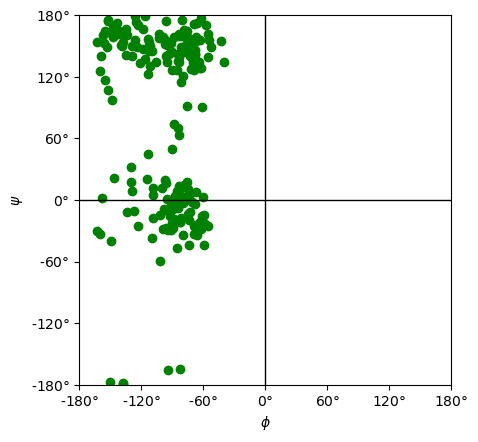

In [9]:
## INSERT CODE HERE ##
import MDAnalysis as MDA
import MDAnalysis.transformations as trans
from MDAnalysis.analysis.dihedrals import Ramachandran
import matplotlib.pyplot as plt

u = MDA.Universe('ala2_amber/equilibration.tpr', 'ala2_amber/equilibration_10ns.xtc')

protein = u.select_atoms('protein')
system = u.select_atoms('all')
transforms = [trans.unwrap(protein), trans.center_in_box(protein), trans.wrap(protein)]
u.trajectory.add_transformations(*transforms)

R = Ramachandran(protein).run(step=50)

fig, ax = plt.subplots(figsize=plt.figaspect(1))
R.plot(ax=ax, color='g', marker='o')